# Adding Problem with LSTM and IndRNN #

In [1]:
from keras.models import Sequential
from keras.layers import CuDNNLSTM, RNN, Dense
from keras.optimizers import Adam

from keras_tqdm.tqdm_callback import TQDMCallback

import sys

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

from indrnn import IndRNNCell

Using TensorFlow backend.


In [2]:
def generator(timesteps, batchsize=128):
    while True:
        x = np.random.uniform(0, 1, size=(batchsize, timesteps, 1))
        x = np.concatenate([x, np.zeros_like(x)], axis=-1)
        x[:, np.random.randint(0, timesteps, size=2), 1] = 1

        y = np.expand_dims(np.sum(np.prod(x, axis=-1), axis=-1), axis=-1)

        yield x, y

        
batchsize = 128
epochs = 100
steps = 100

gen_100 = generator(100, batchsize)

## LSTM Test ##

In [11]:
lstm = Sequential()
lstm.add(CuDNNLSTM(128, input_shape=(100, 2)))
lstm.add(Dense(1))

lstm.compile(optimizer=Adam(0.002, amsgrad=False), loss='mse')
lstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_4 (CuDNNLSTM)     (None, 128)               67584     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 67,713
Trainable params: 67,713
Non-trainable params: 0
_________________________________________________________________


In [12]:
lstm_hist = lstm.fit_generator(gen_100, 
                               steps_per_epoch=steps, 
                               epochs=epochs,
                               callbacks=[
                                   TQDMCallback(leave_inner=False,
                                                output_file=sys.__stdout__)
                               ],
                               verbose=0)

## IndRNN Test ##

In [5]:
indrnn = Sequential()
indrnn.add(RNN([
        IndRNNCell(128),
        IndRNNCell(128)
    ], input_shape=(100, 2)))
indrnn.add(Dense(1))

indrnn.compile(optimizer=Adam(0.0002, amsgrad=False), loss='mse')
indrnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rnn_1 (RNN)                  (None, 128)               17152     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 17,281
Trainable params: 17,281
Non-trainable params: 0
_________________________________________________________________


In [6]:
indrnn_hist = indrnn.fit_generator(gen_100, 
                                   steps_per_epoch=steps, 
                                   epochs=epochs,
                                   callbacks=[
                                       TQDMCallback(leave_inner=False,
                                                    output_file=sys.__stdout__)
                                   ],
                                   verbose=0)

## Comparison ##

In [13]:
losses = []

for hs in [lstm_hist, indrnn_hist]:
    df = pd.DataFrame(index=range(epochs))
    df.index.rename('Epoch', True)
    df['Loss'] = hs.history['loss']
    df['RNN'] = 'LSTM' if hs is lstm_hist else 'IndRNN'
    losses.append(df)

losses = pd.concat(losses)
losses.head()

,Loss,RNN
Epoch,,
0,0.199443,LSTM
1,0.177778,LSTM
2,0.167373,LSTM
3,0.172410,LSTM
4,0.168577,LSTM


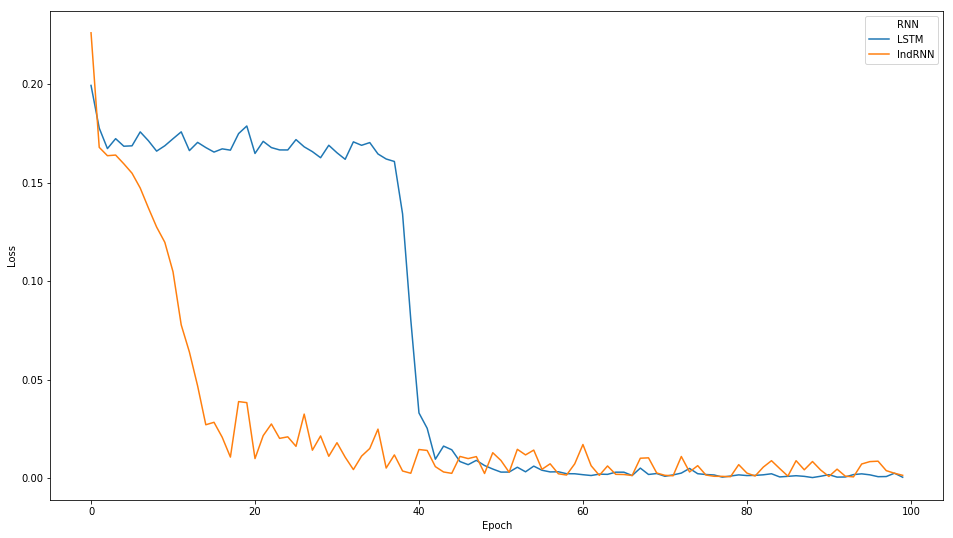

In [14]:
fig, ax = plt.subplots(figsize=(16, 9))

sns.lineplot(data=losses, x=losses.index, y='Loss', hue='RNN', ax=ax)
plt.show()